# Using the ml4qc package for a specific example analysis ("CATI1")

This workbook demonstrates an example analysis for a particular CATI survey example, using data collected with [SurveyCTO](https://www.surveycto.com). To preserve project confidentiality, the project is simply referred to as "CATI1".

In [1]:
# for convenience, auto-reload modules when they've changed
%load_ext autoreload
%autoreload 2

## Loading data from SurveyCTO export

Here, we load the data and prep it for analysis. This includes loading and then processing all [text audits](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zd.field-types-text-audit.html), converting from the original long format (one `.csv` file per submission) to a wide format that we merge into the main dataset. In addition to the text audit files, the main .csv file includes the following columns:

* **SubmissionDate** - Date submission received by SurveyCTO server
* **starttime** - Device date and time form was first opened to fill out
* **endtime** - Device date and time form was completed
* **duration** - Total number of seconds spent editing form
* **instance_time** - Timestamp in an unusual format; will be dropped
* **TA** - Relative path to text audit `.csv` file
* **pct_conversation** - Percent of form-editing time when conversation was detected ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **review_status** - Current review status (APPROVED, REJECTED, or NONE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **review_quality** - Reviewed submission quality (GOOD, OKAY, POOR, or FAKE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **KEY** - Unique submission ID

In [2]:
%%time

import os
import pandas as pd
import pytz
from surveydata import SurveyCTOPlatform
from surveydata import SurveyCTOExportStorage

# manually set our data and collection timezones (b/c storage and text audit formats don't automatically include timezone info)
data_tz = pytz.timezone("Asia/Kabul").zone
collection_tz = pytz.timezone("Asia/Kabul").zone

# initialize local storage with .csv file and attachments_available=True since media subdirectory is present
storage = SurveyCTOExportStorage(export_file=os.path.expanduser("~/ml4qc-data/collab1/cati1/cati1.csv"), attachments_available=True)

# load all submissions into DataFrame and describe contents
submissions_df = SurveyCTOPlatform.get_submissions_df(storage)
print("Submission DataFrame field counts:")
print(submissions_df.count(0))
print()

# summarize submission review status and quality
print("Submission DataFrame review status and quality:")
print(submissions_df.review_status.value_counts())
print(submissions_df.review_quality.value_counts())
print()

# load all text audits into DataFrame and describe contents
textaudit_df = SurveyCTOPlatform.get_text_audit_df(storage, location_strings=submissions_df.TA)
if textaudit_df is not None:
    print("Text audit DataFrame field counts:")
    print(textaudit_df.count(0))
    print()

    # summarize text audits
    ta_summary = SurveyCTOPlatform.process_text_audits(textaudit_df, submissions_df["starttime"], submissions_df["endtime"], data_tz, collection_tz)

    # merge text audit summaries with submission data
    all_data = pd.concat([submissions_df, ta_summary], axis='columns', join='outer', verify_integrity=True)

    # print summary of combined DataFrame
    print("Combined DataFrame field counts:")
    print(all_data.count(0))
else:
    print("No text audits found.")

Submission DataFrame field counts:
SubmissionDate      6032
starttime           6032
endtime             6031
duration            6032
instance_time       6032
TA                  6032
pct_conversation    6031
review_status       6032
review_quality      6032
dtype: int64

Submission DataFrame review status and quality:
APPROVED    5800
REJECTED     232
Name: review_status, dtype: Int64
OKAY    2992
GOOD    2761
POOR     279
Name: review_quality, dtype: Int64

Text audit DataFrame field counts:
field         1244960
duration_s    1244960
visited_s     1244960
dtype: int64

Combined DataFrame field counts:
SubmissionDate                                                                              6032
starttime                                                                                   6032
endtime                                                                                     6031
duration                                                                                    6032

## Prepping data for analysis

Here, we organize our features and the classes that we'll be working to predict.

In [64]:
from ml4qc import SurveyML

# optional dimensionality reduction with PCA (None for no PCA, float (0, 1) for % variance to retain
pca = 0.9

# make a copy of the data for analysis, so that we can transform it at will, dropping columns we don't need and rows with missing values
analysis_df = all_data.drop(["instance_time", "SubmissionDate", "starttime", "endtime", "duration", "TA"], axis=1).copy(deep=True)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]

# organize DataFrames with features and classes for prediction
classes_df = analysis_df.loc[:, ["review_status", "review_quality"]]
features_df = analysis_df.drop(["review_status", "review_quality"], axis=1)

# set our target for prediction
# target_description = "APPROVED submissions classified as GOOD quality"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 0), axis=1)
target_description = "REJECTED submissions"
classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "REJECTED" else 0), axis=1)
# target_description = "POOR submissions"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_quality"] == "POOR" else 0), axis=1)
target_df = pd.DataFrame(classes_df["target"])

# create SurveyML object with 75% test vs. train size
surveyml = SurveyML(features_df, target_df, test_size=0.25, cv_when_training=False, random_state=None, verbose=True)

# preprocess data
surveyml.preprocess_for_prediction(pca)

numeric features: 6276
numeric_binary features: 2315
numeric_unit_interval features: 3955
numeric_other features: 6
datetime features: 0
other features: 2
  Starting training set shape: (4522, 6278)
Starting prediction set shape: (1508, 6278)
     Final training set shape: (4522, 405)
   Final prediction set shape: (1508, 405)


In [60]:
from ml4qc import SurveyML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# optional dimensionality reduction with PCA
reduce_dimensions = True

# make a copy of the data for analysis, so that we can transform it at will, dropping columns we don't need and rows with missing values
analysis_df = all_data.drop(["instance_time", "SubmissionDate", "starttime", "endtime", "duration", "TA"], axis=1).copy(deep=True)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]

# organize DataFrames with features and classes for prediction
classes_df = analysis_df.loc[:, ["review_status", "review_quality"]]
features_df = analysis_df.drop(["review_status", "review_quality"], axis=1)

# set our target for prediction
# target_description = "APPROVED submissions classified as GOOD quality"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 0), axis=1)
target_description = "REJECTED submissions"
classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "REJECTED" else 0), axis=1)
# target_description = "POOR submissions"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_quality"] == "POOR" else 0), axis=1)
target_df = pd.DataFrame(classes_df["target"])

# split into training and test subsamples
x_train, x_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.75, random_state=None)

# categorize our features by data type
features_by_type = SurveyML.columns_by_type(features_df)

# transform data for models
if reduce_dimensions:
    # for dimensionality reduction: one-hot encode categorical data, then normalize everything
    dataTransformer = ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), features_by_type["other"])],
                                        remainder='passthrough')

    preprocessing_pipeline = Pipeline(steps=[
        ('transform', dataTransformer),
        ('scale', StandardScaler()),
        ('reduce', PCA(n_components=0.9, svd_solver="full"))
    ])

    print(f" Initial training set shape: {x_train.shape}")
    x_train = preprocessing_pipeline.fit_transform(x_train)
    y_train = y_train.values.ravel()
    x_test = preprocessing_pipeline.transform(x_test)
    y_test = y_test.values.ravel()

    print(f"Post-PCA training set shape: {x_train.shape}")
else:
    # for direct use: leave binary and unit-interval data as-is, rescale other numeric data, one-hot encode categorical data
    dataTransformer = ColumnTransformer([('numeric_other', MinMaxScaler(), features_by_type["numeric_other"]),
                                         ('categorical', OneHotEncoder(handle_unknown='ignore'), features_by_type["other"])], remainder='passthrough')

    preprocessing_pipeline = Pipeline(steps=[
        ('transform', dataTransformer)
    ])

    x_train = dataTransformer.fit_transform(x_train)
    y_train = y_train.values.ravel()
    x_test = dataTransformer.transform(x_test)
    y_test = y_test.values.ravel()

# Save some basic stats on the training set
total_train = y_train.size
pos_train = y_train.sum()
neg_train = y_train.size - y_train.sum()

#  Define class weights that can help to make up for class imbalance (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
classWeights = {0: (1/neg_train)*(total_train/2.0), 1: (1/pos_train)*(total_train/2.0)}

print(f"Training set: {x_train.shape} ({pos_train} positive)")

KeyboardInterrupt: 

In [32]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score, precision_recall_curve, roc_auc_score, RocCurveDisplay, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Master function to run and evaluate a model
def runmodel(classifier, crossValidate: bool=True):
    # Train the model and derive predictions for the test set
    classifier.fit(x_train, y_train)
    prediction_train=classifier.predict(x_train)
    prediction=classifier.predict(x_test)
    prediction_proba=classifier.predict_proba(x_test)[:, 1]

    # High-level model evaluation
    print("Train accuracy: ",'{0:.2%}'.format(accuracy_score(y_train, prediction_train)))
    print("Train precision: ",'{0:.2%}'.format(precision_score(y_train, prediction_train)))
    print("Train F-1: ",'{0:.2}'.format(f1_score(y_train, prediction_train)))
    print("Test accuracy: ",'{0:.2%}'.format(accuracy_score(y_test, prediction)))
    print("Test precision: ",'{0:.2%}'.format(precision_score(y_test, prediction)))
    print("Test F-1: ",'{0:.2}'.format(f1_score(y_test, prediction)))
    print("Test ROC_AUC Score: ",'{0:.2}'.format(roc_auc_score(y_test, prediction)))
    if crossValidate:
        print("Cross validation results: ")
        # Cross validation with F-1 scoring due to imbalanced classes
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=None)
        # (note that scores depend on classification vs. regression: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
        cv_scores = cross_validate(classifier, x_train, y_train, cv=cv, scoring=('f1', 'balanced_accuracy', 'roc_auc'))
        for score_key, score_value in cv_scores.items():
            print(f"{score_key}: {np.mean(score_value)} (SD: {np.std(score_value)})")
    if x_test is not None:
        RocCurveDisplay.from_predictions(y_test, prediction)
        plt.title('ROC_AUC_Plot')
        plt.show()

    # Plot predicted probabilities against the truth
    plt.figure(figsize=(15,7))
    plt.hist(prediction_proba[(y_test == 0) & (prediction == 0)], bins=50, range=(0,1), label='True negatives', color='lightgrey')
    plt.hist(prediction_proba[(y_test == 0) & (prediction == 1)], bins=50, range=(0,1), label='False positives', color='grey')
    plt.hist(prediction_proba[(y_test == 1) & (prediction == 0)], bins=50, range=(0,1), label='False negatives', alpha=0.7, color='r')
    plt.hist(prediction_proba[(y_test == 1) & (prediction == 1)], bins=50, range=(0,1), label='True positives', alpha=0.7, color='g')
    plt.axvline(0.5, color='k', linestyle='dashed', linewidth=1)
    plt.title("Predicted probabilities for test set")
    plt.xlabel('P(Positive)', fontsize=25)
    plt.legend(fontsize=15)
    plt.tick_params(axis='both', labelsize=25, pad=5)
    plt.show()

    # Confusion Matrix
    cm=confusion_matrix(y_test, prediction)
    names=['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts=[value for value in cm.flatten()]
    percentages=['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels=[f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels=np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')
    # Summarize conditional probabilities
    tn, fp, fn, tp = cm.ravel()
    print("Test P(1) = ", '{0:.2%}'.format(y_test.sum()/y_test.size))
    print("Test P(1 | predicted 1) = ", '{0:.2%}'.format(tp/(tp+fp)))
    print("Test P(1 | predicted 0) = ", '{0:.2%}'.format(fn/(tn+fn)))
    print()

    # Classification report
    print(classification_report(y_test, prediction))

    # Plot precision-recall curve
    #   calculate precision and recall
    precision, recall, thresholds=precision_recall_curve(y_test, prediction_proba)
    #   create precision recall curve
    fig, ax=plt.subplots()
    ax.plot(recall, precision, color='purple')
    #   add axis labels to plot
    ax.set_title('Precision-recall curve (test set)')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    #   display plot
    plt.show()

def featureimportance(importance: np.ndarray):
    # Summarize feature importance
    print("FEATURE IMPORTANCE")
    sortedNamePlusImportance = sorted(zip(dataTransformer.get_feature_names_out(), importance), key=lambda x: abs(x[1]), reverse=True)
    for namePlusImportance in sortedNamePlusImportance:
        print('Feature: %s, Score: %.5f' % (namePlusImportance[0], namePlusImportance[1]))

  Predicting: REJECTED submissions
       Model: Logistic regression
Training set: (1507, 319) (43 positive)
    Test set: (4523, 319)

Train accuracy:  97.41%
Train precision:  52.44%
Train F-1:  0.69
Test accuracy:  92.88%
Test precision:  24.32%
Test F-1:  0.28
Test ROC_AUC Score:  0.64
Cross validation results: 
fit_time: 0.05807586510976156 (SD: 0.009505253321971177)
score_time: 0.0038871208826700846 (SD: 0.0008449767602024487)
test_f1: 0.197148477883772 (SD: 0.13058075079738515)
test_balanced_accuracy: 0.6320287018917156 (SD: 0.11203126020150361)
test_roc_auc: 0.7126530612244897 (SD: 0.12816654839965858)


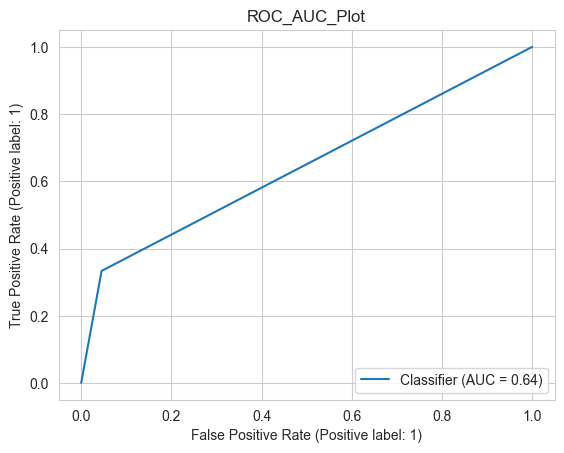

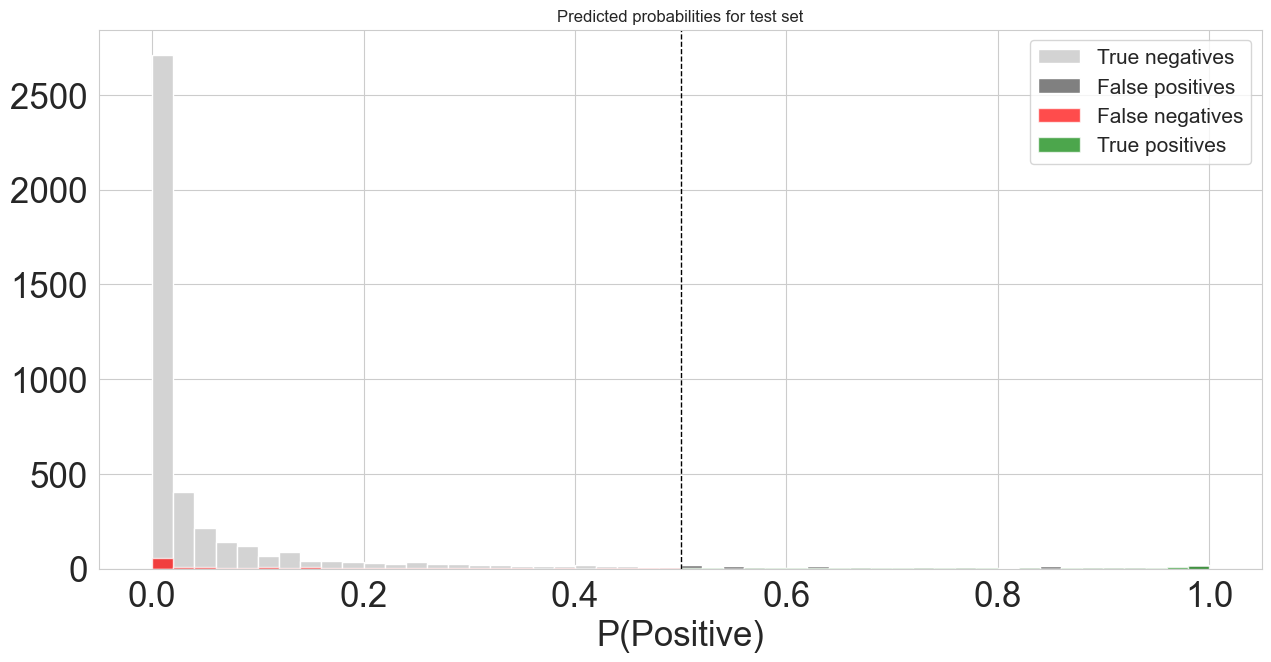

Test P(1) =  4.18%
Test P(1 | predicted 1) =  24.32%
Test P(1 | predicted 0) =  2.95%

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4334
           1       0.24      0.33      0.28       189

    accuracy                           0.93      4523
   macro avg       0.61      0.64      0.62      4523
weighted avg       0.94      0.93      0.93      4523



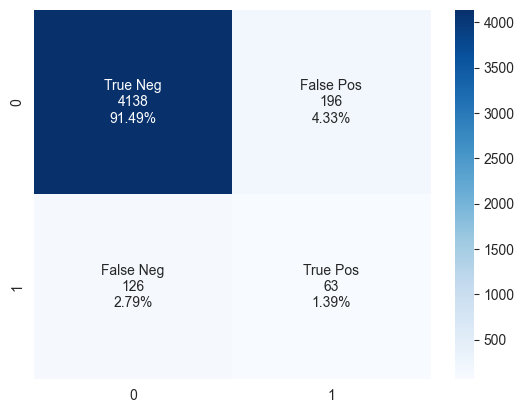

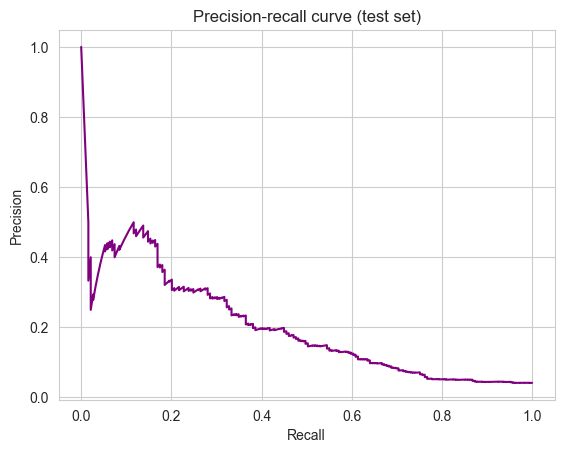

FEATURE IMPORTANCE
Feature: remainder__ta_field_form_questions_1_Roster_1_Labor_2_Labor_Group_1_Currently_Working_Respondent_visited, Score: -0.18094
Feature: remainder__ta_field_form_questions_1_Roster_Verification_5_HH_Mem_Relationship_to_Head_of_HH_Ver_visit_1_start, Score: -0.17195
Feature: remainder__ta_field_form_questions_1_Roster_1_Labor_1_Labor_Group_1_L16a_visit_1_duration, Score: -0.16519
Feature: remainder__ta_field_form_questions_1_Roster_1_Labor_2_Labor_Group_1_labor_note_visit_1_start, Score: -0.15845
Feature: remainder__ta_field_form_questions_1_Roster_Verification_4_HH_Mem_Relationship_to_Head_of_HH_Ver_visit_1_duration, Score: 0.15056
Feature: remainder__ta_field_form_questions_1_Roster_Verification_9_HH_Mem_Relationship_to_Head_of_HH_Ver_visit_1_duration, Score: 0.14780
Feature: remainder__ta_field_form_questions_1_Intro_06_visit_1_start, Score: -0.14726
Feature: remainder__ta_field_form_questions_1_Roster_1_Labor_1_Labor_Group_1_L03_visited, Score: -0.14550
Feature:

In [34]:
%%time

model_description = "Logistic regression"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"Training set: {x_train.shape} ({pos_train} positive)")
print(f"    Test set: {x_test.shape}")
print()

from sklearn.linear_model import LogisticRegression

classifier_lr = LogisticRegression(random_state=None, C=0.01, penalty='l2', max_iter=10000, class_weight=classWeights)
runmodel(classifier_lr, crossValidate=True)
featureimportance(classifier_lr.coef_[0])

  Predicting: REJECTED submissions
       Model: Decision tree
Training set: (1507, 319) (43 positive)
    Test set: (4523, 319)

Train accuracy:  97.21%
Train precision:  50.59%
Train F-1:  0.67
Test accuracy:  90.80%
Test precision:  9.89%
Test F-1:  0.12
Test ROC_AUC Score:  0.54


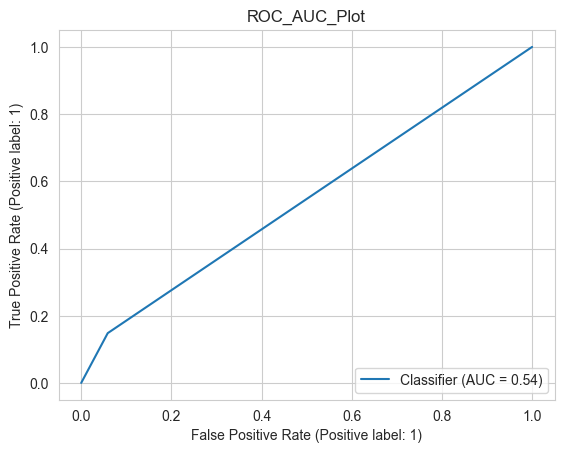

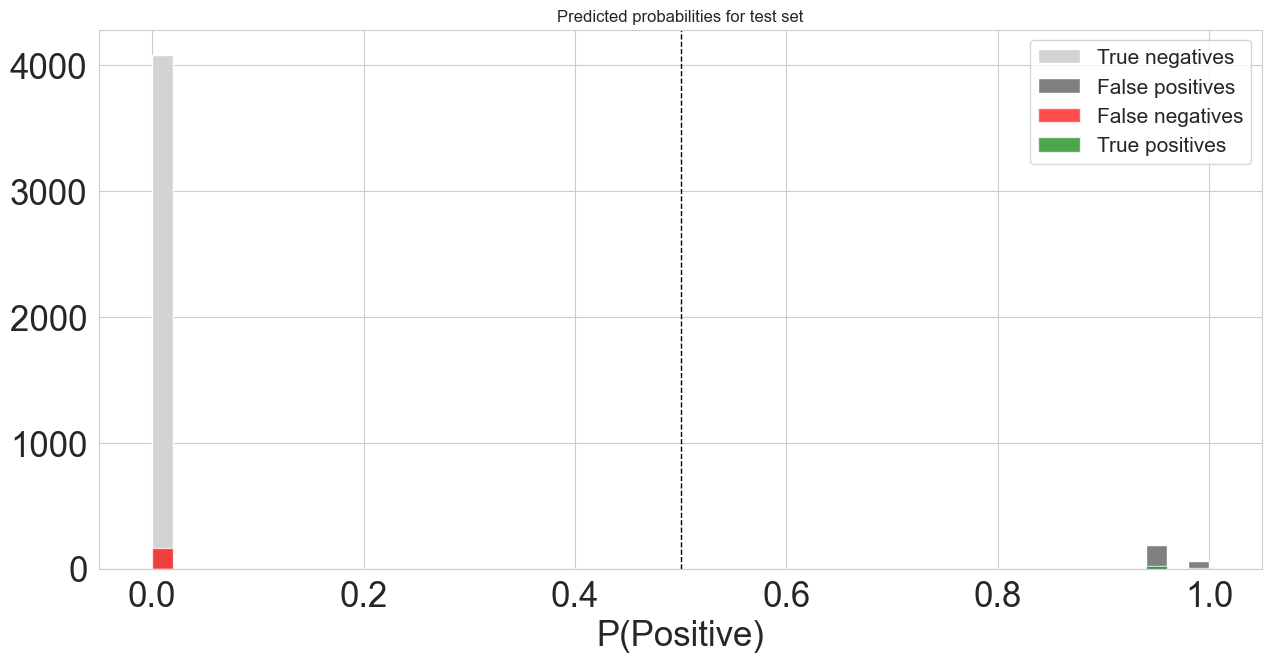

Test P(1) =  4.18%
Test P(1 | predicted 1) =  9.89%
Test P(1 | predicted 0) =  3.80%

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4334
           1       0.10      0.15      0.12       189

    accuracy                           0.91      4523
   macro avg       0.53      0.54      0.54      4523
weighted avg       0.93      0.91      0.92      4523



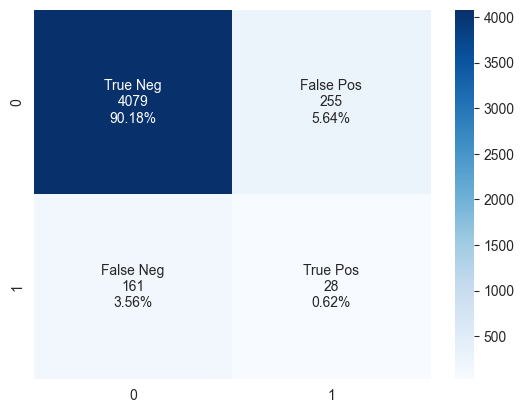

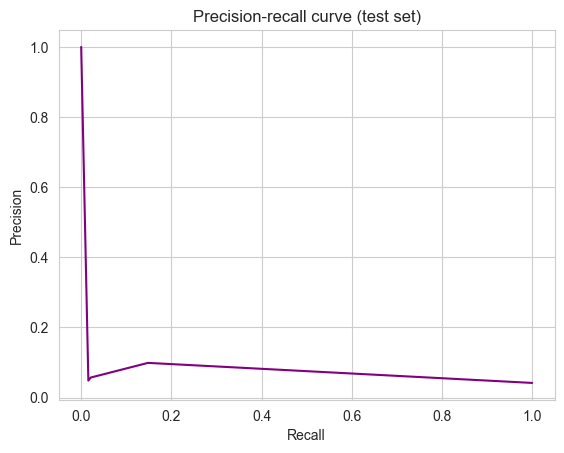

FEATURE IMPORTANCE
Feature: categorical__ta_start_hourofday_1, Score: 0.20683
Feature: remainder__ta_field_form_questions_1_Roster_Verification_5_HH_Mem_Relationship_to_Head_of_HH_Ver_visit_1_start, Score: 0.13481
Feature: remainder__ta_field_form_questions_1_Roster_1_Labor_3_Labor_Group_1_L15_visit_1_duration, Score: 0.08806
Feature: remainder__ta_field_form_questions_1_Roster_Verification_8_Roster_Gender_Ver_visit_1_duration, Score: 0.07759
Feature: categorical__ta_start_hourofday_6, Score: 0.07111
Feature: remainder__ta_field_Reached_out_to_respondent_visit_1_start, Score: 0.06954
Feature: remainder__ta_field_form_questions_1_Roster_Verification_9_Roster_Age_Ver_visited, Score: 0.06505
Feature: remainder__ta_field_form_questions_1_Roster_1_Labor_3_Labor_Group_1_L02_visit_1_start, Score: 0.06141
Feature: remainder__ta_field_form_questions_1_Roster_Verification_1_Roster_Name_Ver_visited, Score: 0.03856
Feature: remainder__ta_field_note_intro_visit_1_duration, Score: 0.03600
Feature: r

In [20]:
%%time

model_description = "Decision tree"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"Training set: {x_train.shape} ({pos_train} positive)")
print(f"    Test set: {x_test.shape}")
print()

from sklearn.tree import DecisionTreeClassifier

classifier_dt = DecisionTreeClassifier(random_state=None, class_weight=classWeights, max_depth=10, min_samples_leaf=2)

runmodel(classifier_dt, crossValidate=False)
featureimportance(classifier_dt.feature_importances_)

  Predicting: REJECTED submissions
       Model: Random forest
Training set: (1507, 319) (43 positive)
    Test set: (4523, 319)

Train accuracy:  99.80%
Train precision:  100.00%
Train F-1:  0.96
Test accuracy:  95.89%
Test precision:  80.00%
Test F-1:  0.041
Test ROC_AUC Score:  0.51


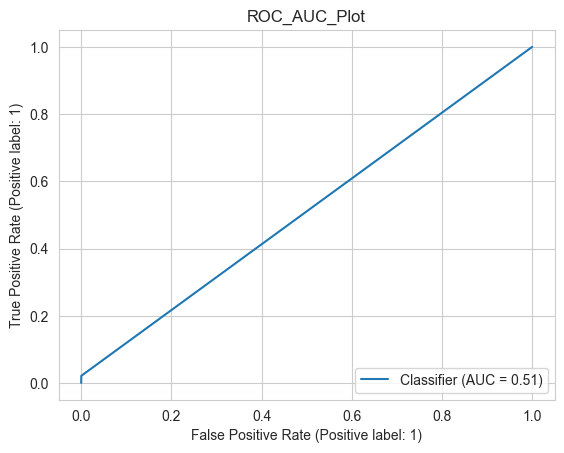

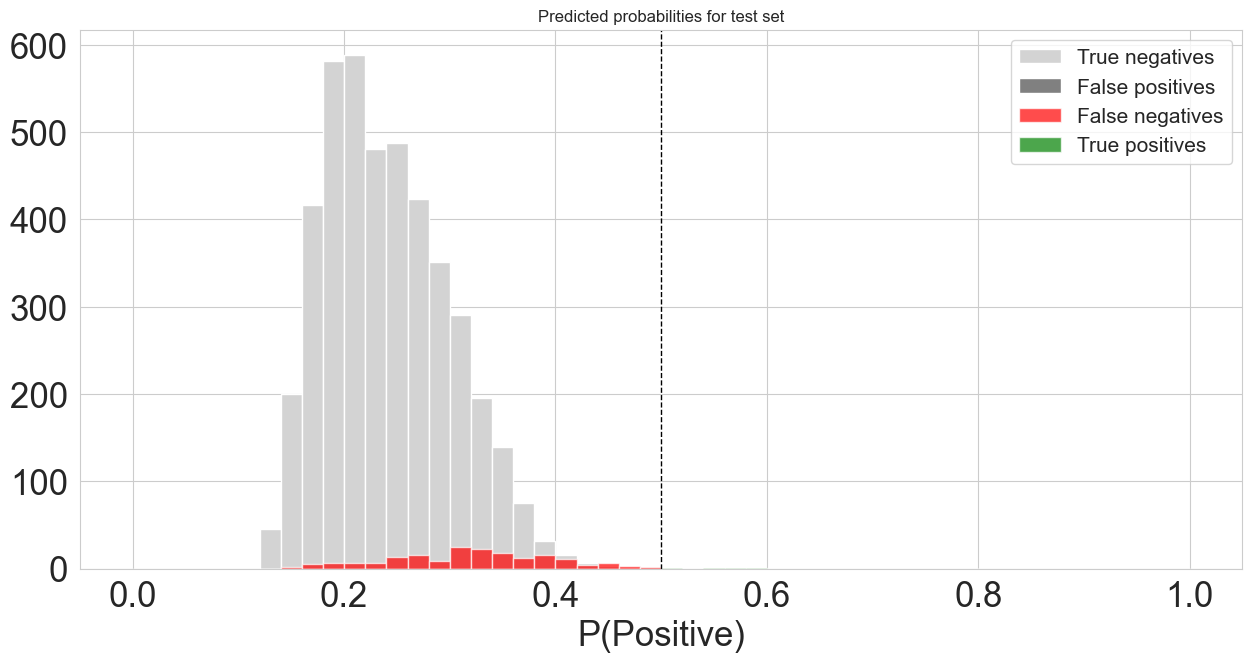

Test P(1) =  4.18%
Test P(1 | predicted 1) =  80.00%
Test P(1 | predicted 0) =  4.09%

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4334
           1       0.80      0.02      0.04       189

    accuracy                           0.96      4523
   macro avg       0.88      0.51      0.51      4523
weighted avg       0.95      0.96      0.94      4523



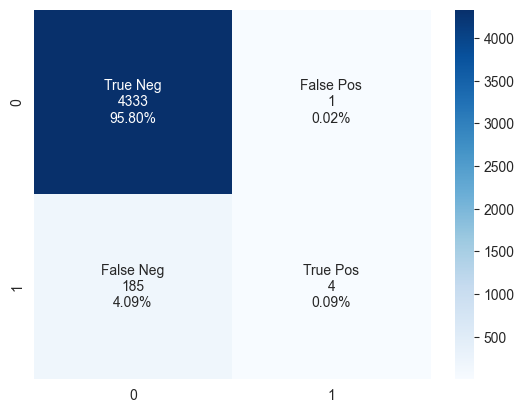

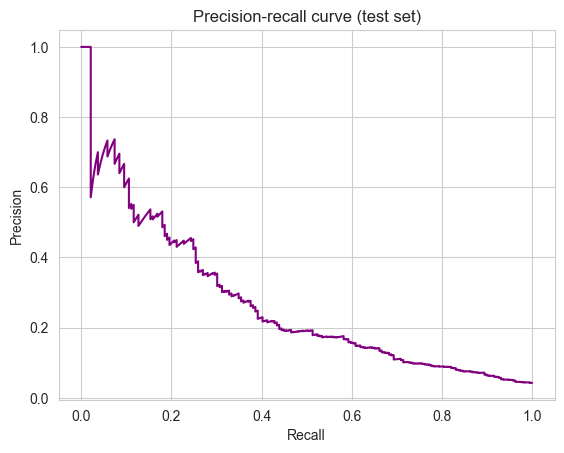

FEATURE IMPORTANCE
Feature: categorical__ta_start_hourofday_1, Score: 0.05212
Feature: remainder__ta_field_Reached_out_to_respondent_visit_1_start, Score: 0.02828
Feature: remainder__ta_field_form_questions_1_Roster_Verification_4_Roster_Age_Ver_visit_1_start, Score: 0.02340
Feature: remainder__ta_field_form_questions_1_Roster_1_Labor_2_Labor_Group_1_Currently_Working_Respondent_visited, Score: 0.01865
Feature: categorical__ta_start_hourofday_10, Score: 0.01633
Feature: categorical__ta_start_dayofweek_5, Score: 0.01426
Feature: remainder__ta_field_form_questions_1_Intro_02_visit_1_duration, Score: 0.01404
Feature: remainder__ta_field_form_questions_1_Roster_Verification_5_HH_Mem_Relationship_to_Head_of_HH_Ver_visit_1_start, Score: 0.01388
Feature: categorical__ta_start_hourofday_12, Score: 0.01306
Feature: remainder__ta_field_HH_Age_visit_1_duration, Score: 0.01109
Feature: remainder__ta_field_Can_I_Speack_to_Household_Head_visited, Score: 0.01055
Feature: remainder__ta_field_form_ques

In [25]:
%%time

model_description = "Random forest"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"Training set: {x_train.shape} ({pos_train} positive)")
print(f"    Test set: {x_test.shape}")
print()

from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=None, n_estimators=1000, class_weight="balanced", max_depth=3, min_samples_leaf=1)

runmodel(classifier_rf, crossValidate=False)
featureimportance(classifier_rf.feature_importances_)

  Predicting: REJECTED submissions
       Model: XGBoost
Training set: (1507, 319) (43 positive)
    Test set: (4523, 319)

Train accuracy:  100.00%
Train precision:  100.00%
Train F-1:  1.0
Test accuracy:  95.84%
Test precision:  52.00%
Test F-1:  0.12
Test ROC_AUC Score:  0.53


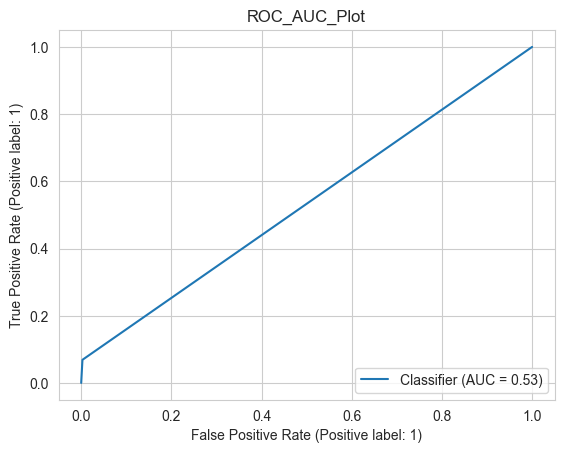

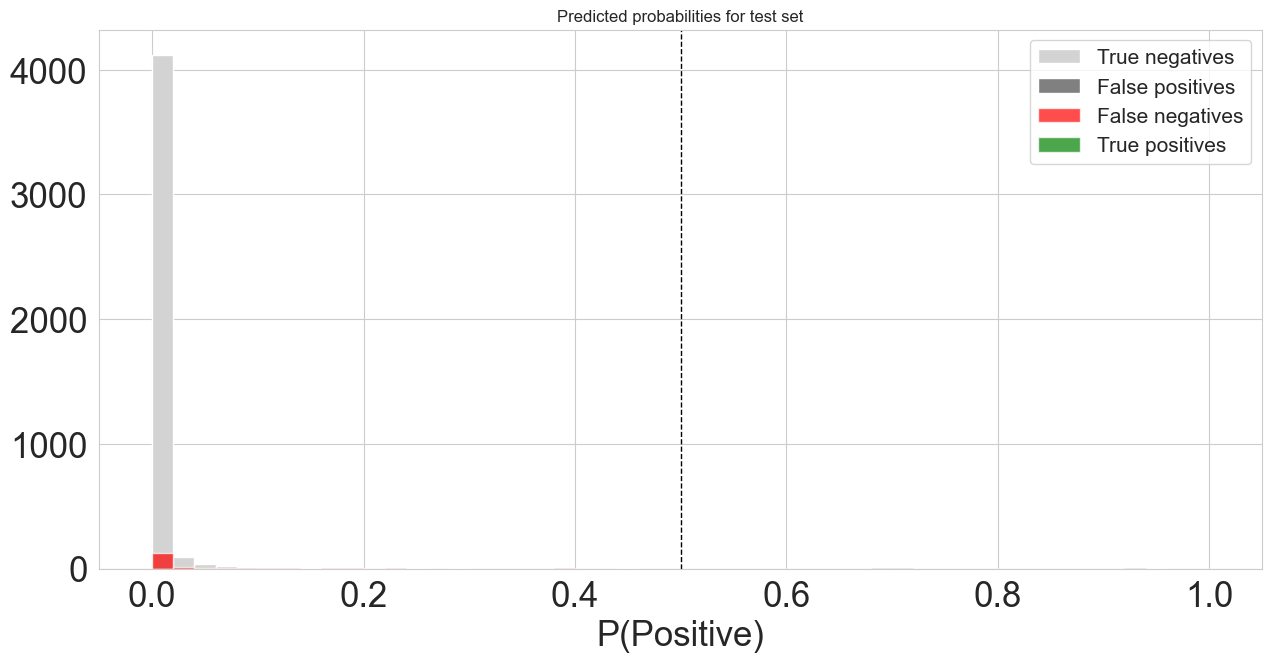

Test P(1) =  4.18%
Test P(1 | predicted 1) =  52.00%
Test P(1 | predicted 0) =  3.91%

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4334
           1       0.52      0.07      0.12       189

    accuracy                           0.96      4523
   macro avg       0.74      0.53      0.55      4523
weighted avg       0.94      0.96      0.94      4523



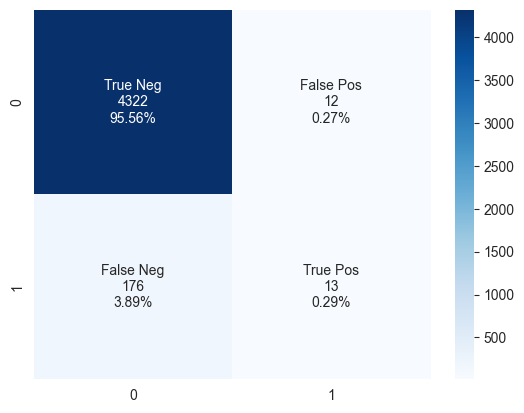

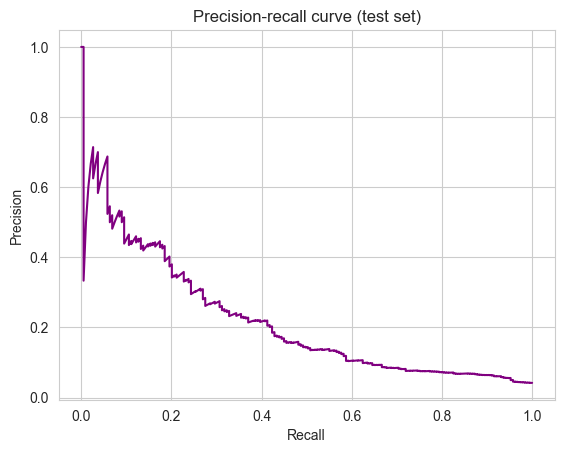

FEATURE IMPORTANCE
Feature: remainder__ta_field_form_questions_1_Roster_Verification_8_Roster_Gender_Ver_visit_1_start, Score: 0.08934
Feature: remainder__ta_field_Surveyor_Name_visited, Score: 0.07167
Feature: remainder__ta_field_form_questions_1_Roster_Verification_9_HH_Mem_Relationship_to_Head_of_HH_Ver_visit_1_duration, Score: 0.06188
Feature: categorical__ta_start_hourofday_1, Score: 0.04952
Feature: remainder__ta_field_form_questions_1_Roster_Verification_4_Ability_To_Read_Write_Existing_Roster_visit_1_duration, Score: 0.04559
Feature: categorical__ta_start_hourofday_6, Score: 0.03492
Feature: remainder__ta_field_form_questions_1_Roster_Verification_5_HH_Mem_Relationship_to_Head_of_HH_Ver_visit_1_start, Score: 0.02738
Feature: remainder__ta_field_form_questions_1_Roster_Verification_1_Roster_Name_Ver_visited, Score: 0.02617
Feature: remainder__ta_field_form_questions_1_Roster_Verification_6_Roster_Gender_Ver_visit_1_start, Score: 0.02176
Feature: remainder__ta_field_Reached_out_t

In [27]:
%%time

model_description = "XGBoost"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"Training set: {x_train.shape} ({pos_train} positive)")
print(f"    Test set: {x_test.shape}")
print()

from xgboost import XGBClassifier

classifier_xb = XGBClassifier(objective='binary:logistic', eval_metric='aucpr', max_depth=3, scale_pos_weight=neg_train/pos_train, use_label_encoder=False)

runmodel(classifier_xb, crossValidate=False)
featureimportance(classifier_xb.feature_importances_)

  Predicting: REJECTED submissions
       Model: Neural network
Training set: (1507, 333) (59 positive)
    Test set: (4523, 333)

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_123 (Dense)           (None, 333)               111222    
                                                                 
 dropout_67 (Dropout)        (None, 333)               0         
                                                                 
 dense_124 (Dense)           (None, 166)               55444     
                                                                 
 dropout_68 (Dropout)        (None, 166)               0         
                                                                 
 dense_125 (Dense)           (None, 1)                 167       
                                                                 
Total params: 166,833
Trainable params: 166,833
Non-tr

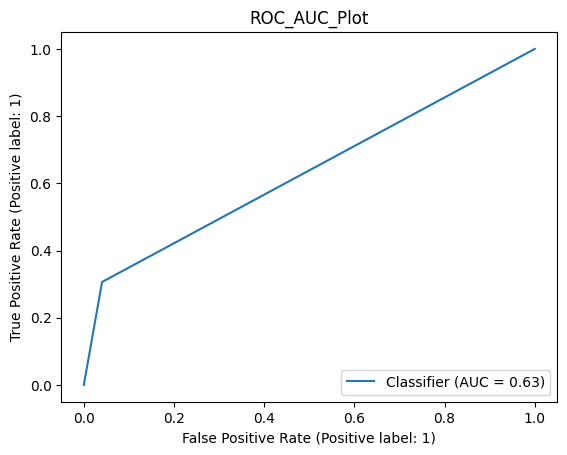

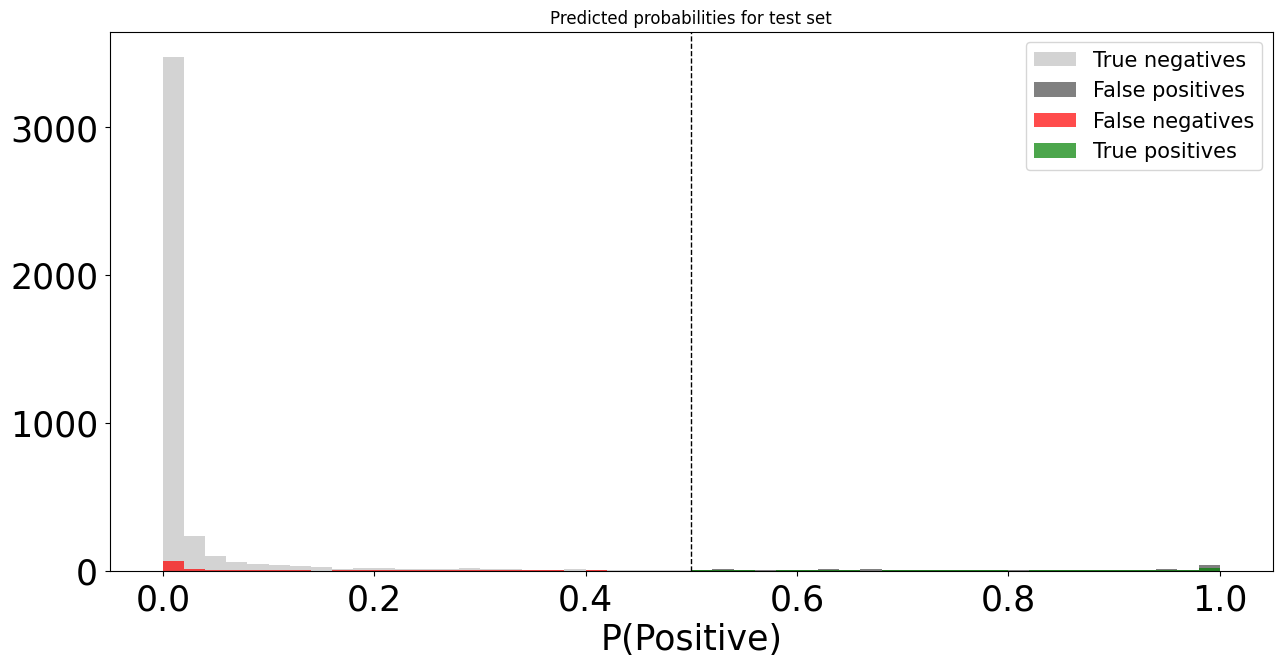

Test P(1) =  3.82%
Test P(1 | predicted 1) =  23.14%
Test P(1 | predicted 0) =  2.79%

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4350
           1       0.23      0.31      0.26       173

    accuracy                           0.93      4523
   macro avg       0.60      0.63      0.61      4523
weighted avg       0.94      0.93      0.94      4523



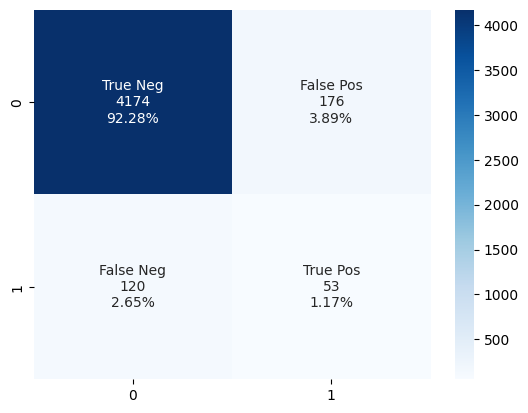

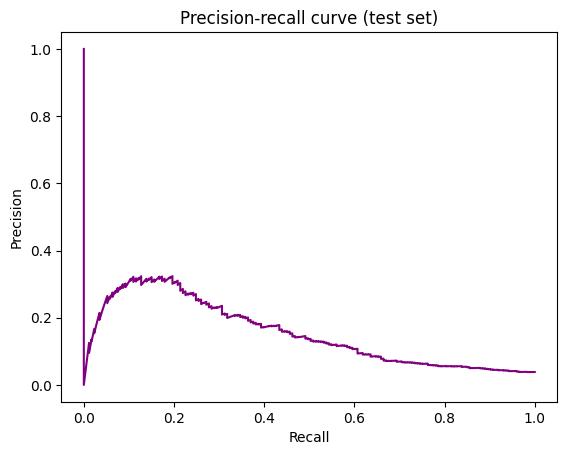

CPU times: user 19.8 s, sys: 4.58 s, total: 24.4 s
Wall time: 10.5 s


In [152]:
%%time

model_description = "Neural network"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"Training set: {x_train.shape} ({pos_train} positive)")
print(f"    Test set: {x_test.shape}")
print()

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from scikeras.wrappers import KerasClassifier

# set regularization and dropout hyperparameters
l2factor = 0.01
dropoutRate = 0.01
#  use initial bias to match imbalance in classes (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
output_bias = Constant(np.log([pos_train/neg_train]))
# create neural network model
nnmodel=Sequential()
nnmodel.add(Dense(x_train.shape[1], kernel_regularizer=l2(l2factor), activation='relu', input_shape=(x_train.shape[1], )))
nnmodel.add(Dropout(dropoutRate))
nnmodel.add(Dense(x_train.shape[1]/2, kernel_regularizer=l2(l2factor), activation='relu'))
nnmodel.add(Dropout(dropoutRate))
nnmodel.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))
# compile model
nnmodel.compile(loss='binary_crossentropy', optimizer='adam',
                metrics=[
                    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')])
print(nnmodel.summary())

# create classifier and run model
# classifier_nn = KerasClassifier(nnmodel, epochs=100, batch_size=32, verbose=0, class_weight=classWeights)
classifier_nn = KerasClassifier(nnmodel, epochs=40, verbose=0, class_weight=classWeights)
runmodel(classifier_nn, crossValidate=False)

In [55]:
model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print(f"Training set: {x_train.shape} ({pos_train} positive)")
print(f"    Test set: {x_test.shape}")
print()

from sklearn.ensemble import IsolationForest
if_classifier = IsolationForest()
x_train_outlier = (if_classifier.fit_predict(surveyml.x_train_preprocessed) == -1)
x_test_outlier = (if_classifier.predict(surveyml.x_predict_preprocessed) == -1)

print(f"Training set outliers: {x_train_outlier.sum()} ({x_train_outlier.sum() / len(x_train) * 100}%)")
print(f"    Test set outliers: {x_test_outlier.sum()} ({x_test_outlier.sum() / len(x_test) * 100}%)")

pd.crosstab(x_test_outlier, y_test).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection
Training set: (1507, 324) (60 positive)
    Test set: (4523, 324)

Training set outliers: 40 (2.6542800265428004%)
    Test set outliers: 232 (5.1293389343356175%)


col_0,0,1
row_0,,
False,0.948058,0.965116
True,0.051942,0.034884


In [73]:
model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print()

x_outlier_df = surveyml.identify_outliers()

x_outlier_df = x_outlier_df.join(target_df)
pd.crosstab(x_outlier_df.is_outlier, x_outlier_df.target).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection

Outliers: 99 (1.6417910447761193%)


target,0,1
is_outlier,,
False,0.983443,0.987069
True,0.016557,0.012931
